# MNIST_MLP 실험

# **1. overview**

 해당 실험은 기계학습의 기초가 되는 다중 신경망을 이용한다. MNIST dataset을 학습 데이터로 하는 모델의 학습과 평가가 실험 대상이다. 실험 목적은 학습률 (learning rate), epoch와 신경망 내의 활성화 함수 (activation function)를 변인으로 하여, 평가 데이터셋에 대한 최종 정확도와 에포크당 학습 loss의 수렴 정도를 Dynamic Mode Decomposition (DMD) 기법을 이용해 이를 보조 지표로 비교 및 분석하는 것이다. 그리고 그 분석을 통해 모델의 성능을 개선할 수 있는 아이디어를 찾는 것이다.

# **2. experimental setting**



필요한 라이브러리를 import, 하드웨어 확인

In [34]:
# imports 완료 + 하드웨어 확인 출력
import os, time, csv, random
from collections import Counter
from typing import List, Tuple, Dict, Any

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from datasets import load_dataset
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if device.type == "cuda":
    try:
        print(f"GPU: {torch.cuda.get_device_name(0)}")
    except Exception:
        pass


Device: cuda
GPU: Tesla T4


모델 학습 데이터가 되는  MNIST를 다운로드, 정규화 실행.
파이토치의 dataset을 상속하는 class를 만들어보기

In [35]:
# MNIST를 다운로드, transform, DataLoader를 정의해 둡니다.
print("Downloading MNIST (if not cached)...")
mnist = load_dataset("mnist")  # HF datasets

# 표준 MNIST mean/std (튜토리얼에서 나왔던 통계값 도출입니다)
MNIST_MEAN = (0.1307,)
MNIST_STD  = (0.3081,)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MNIST_MEAN, MNIST_STD)
])

# flatten(28*28 -> 784) 처리 및 dataloader가 여러번 쓰인다고 알고 있어서 해당 과정이 반복해서 실행될 수 있도록 class를 LLM의 도움을 받아 구상했습니다.
class HFDatasetWrapper(Dataset):
    def __init__(self, hf_ds, transform=None):
        self.ds = hf_ds
        self.transform = transform
    def __len__(self):
        return len(self.ds)
    def __getitem__(self, idx):
        item = self.ds[idx]
        img = item["image"]
        lbl = int(item["label"])
        if self.transform:
            img = self.transform(img)
        img = img.view(-1)  # flatten -> (784,)
        return {"image": img, "label": torch.tensor(lbl, dtype=torch.long)}

train_ds = HFDatasetWrapper(mnist["train"], transform=transform)
test_ds  = HFDatasetWrapper(mnist["test"],  transform=transform)

print("Train size:", len(train_ds), "Test size:", len(test_ds))

Train size: 60000 Test size: 10000


3층의 신경망을 가진 MLP 모델

In [29]:
# 튜토리얼에 있던 fc 모델을 그래로 가져와 사용했습니다.
class MLP(nn.Module):
    def __init__(self, input_size=784, hidden_size=100, num_classes=10):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes)
        )
    def forward(self, x):
        return self.layers(x)

# 모델 확인 (간단 샘플)
_model = MLP()
total_params = sum(p.numel() for p in _model.parameters())
trainable_params = sum(p.numel() for p in _model.parameters() if p.requires_grad)
print("MLP summary:")
print(_model)
print(f"Total params: {total_params:,}, Trainable: {trainable_params:,}")

MLP summary:
MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)
Total params: 79,510, Trainable: 79,510


In [31]:
def set_seed(seed: int = 42):
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def make_loaders(batch_size: int = 128, test_batch_size: int = 1000, num_workers: int = 2):
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=num_workers)
    test_loader  = DataLoader(test_ds,  batch_size=test_batch_size, shuffle=False, num_workers=num_workers)
    return train_loader, test_loader

def train_one_epoch(model: nn.Module, loader: DataLoader, optimizer: optim.Optimizer, criterion, device) -> float:
    model.train()
    total_loss = 0.0
    n = 0
    for batch in loader:
        imgs = batch["image"].to(device)
        labels = batch["label"].to(device)
        optimizer.zero_grad()
        outs = model(imgs)
        loss = criterion(outs, labels)
        loss.backward()
        optimizer.step()
        bs = imgs.size(0)
        total_loss += float(loss.item()) * bs
        n += bs
    return total_loss / n if n>0 else 0.0

def evaluate(model: nn.Module, loader: DataLoader, criterion, device) -> Tuple[float, float]:
    model.eval()
    total_loss = 0.0
    correct = 0
    n = 0
    with torch.no_grad():
        for batch in loader:
            imgs = batch["image"].to(device)
            labels = batch["label"].to(device)
            outs = model(imgs)
            loss = criterion(outs, labels)
            total_loss += float(loss.item()) * imgs.size(0)
            preds = outs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            n += imgs.size(0)
    avg_loss = total_loss / n if n>0 else 0.0
    acc = 100.0 * correct / n if n>0 else 0.0
    return avg_loss, acc

# **3. experiment 1 : learning rate와 epoch를 변인으로 한 실험을 실행**

(1) learnong rate 실험 : learning rate가 [0.0001, 0.0003, 0.001]일때 에포크를 3씩 각각돌리며 loss의 변화와 최종 정확도를 관찰한다.

(2) epoch 실험 : epoch를 1에서 5까지 학습시킨 모델의 정확도를 관찰한다.

변인값에 따른 모델 학습을 자동화 하기 위한 run_experiments

In [32]:
# 실험에 있어서는 반복 실행이 핵심이라고 알고 있으며 반복 실행을 자동화 하는 알고리즘의 필요성을 느껴 run_experiments 함수의 pipline을 LLM의 도움을 받아 참고 작성하였습니다.

# loss와 관련된 데이터들이 나온 이후로는 데이터 분석의 영역으로 넘어가는 것이라고 생각합니다. 많은 데이터 분석 tool들이 csv 형식의 파일과 친숙하기에 해당 형식으로 로그가 저장되도록 합니다.
# csv 형태의 파일이 만들어지는 부분은 처음 구현해보는 부분이기에 LLM의 참고를 받았습니다.
import math

def run_experiments(
    mode: str = "lr",
    lr_list: List[float] = None,
    epoch_list: List[int] = None,
    baseline_lr: float = 1e-3,
    baseline_epochs: int = 3,
    batch_size: int = 128,
    test_batch_size: int = 1000,
    seed: int = 42,
    results_dir: str = "./exp_results",
    csv_name: str = "results.csv",
    save_best_ckpt: bool = True
) -> Tuple[str, List[Tuple]]:
    """
    mode: 'lr' 또는 'epochs'
    반환: (csv_path, summaries) where summaries = list of (exp_name, lr, epochs, best_val_acc, ckpt_path_or_None)
    """
    assert mode in ("lr", "epochs")
    os.makedirs(results_dir, exist_ok=True)
    csv_path = os.path.join(results_dir, csv_name)

    if lr_list is None:
        lr_list = [1e-4, 3e-4, 1e-3, 3e-3]
    if epoch_list is None:
        epoch_list = [1, 3, 5]

    # CSV 헤더
    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["exp_name", "mode", "value", "epoch", "train_loss", "val_loss", "val_acc", "elapsed_sec", "ckpt"])

    # 공통 로더
    train_loader, test_loader = make_loaders(batch_size=batch_size, test_batch_size=test_batch_size)

    criterion = nn.CrossEntropyLoss()
    summaries = []

    if mode == "lr":
        for lr in lr_list:
            exp_name = f"lr_{lr}"
            print(f"\n=== 실험: {exp_name} | epochs={baseline_epochs} ===")
            set_seed(seed)
            model = MLP().to(device)
            optimizer = optim.Adam(model.parameters(), lr=lr)
            best_val_acc = -math.inf
            best_ckpt = None
            start_total = time.time()

            for ep in range(1, baseline_epochs+1):
                t0 = time.time()
                train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
                val_loss, val_acc = evaluate(model, test_loader, criterion, device)
                elapsed = time.time() - t0

                # 출력
                print(f"[{exp_name}] Ep {ep}/{baseline_epochs} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_acc={val_acc:.2f}%")

                # CSV 기록
                with open(csv_path, "a", newline="") as f:
                    writer = csv.writer(f)
                    writer.writerow([exp_name, "lr", lr, ep, round(train_loss,6), round(val_loss,6), round(val_acc,3), round(elapsed,3), ""])

                # 체크포인트 저장 (최고 val_acc)
                if save_best_ckpt and val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_ckpt = os.path.join(results_dir, f"{exp_name}_best.pth")
                    torch.save({"model_state": model.state_dict(), "lr": lr, "epoch": ep, "val_acc": val_acc}, best_ckpt)

            total_elapsed = time.time() - start_total
            summaries.append((exp_name, lr, baseline_epochs, best_val_acc if best_val_acc!=-math.inf else None, best_ckpt))
            print(f"완료: {exp_name} | best_val_acc={best_val_acc:.2f}% | total_elapsed={total_elapsed:.1f}s | ckpt={best_ckpt}")

    else:  # mode == 'epochs'
        for epochs in epoch_list:
            exp_name = f"ep_{epochs}"
            print(f"\n=== 실험: {exp_name} | lr={baseline_lr} ===")
            set_seed(seed)
            model = MLP().to(device)
            optimizer = optim.Adam(model.parameters(), lr=baseline_lr)
            best_val_acc = -math.inf
            best_ckpt = None
            start_total = time.time()

            for ep in range(1, epochs+1):
                t0 = time.time()
                train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
                val_loss, val_acc = evaluate(model, test_loader, criterion, device)
                elapsed = time.time() - t0

                # 에포크별 출력
                print(f"[{exp_name}] Ep {ep}/{epochs} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_acc={val_acc:.2f}%")

                # CSV 기록
                with open(csv_path, "a", newline="") as f:
                    writer = csv.writer(f)
                    writer.writerow([exp_name, "epochs", epochs, ep, round(train_loss,6), round(val_loss,6), round(val_acc,3), round(elapsed,3), ""])

                # 체크포인트 저장 (최고 val_acc)
                if save_best_ckpt and val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_ckpt = os.path.join(results_dir, f"{exp_name}_best.pth")
                    torch.save({"model_state": model.state_dict(), "lr": baseline_lr, "epoch": ep, "val_acc": val_acc}, best_ckpt)

            total_elapsed = time.time() - start_total
            summaries.append((exp_name, baseline_lr, epochs, best_val_acc if best_val_acc!=-math.inf else None, best_ckpt))
            print(f"완료: {exp_name} | best_val_acc={best_val_acc:.2f}% | total_elapsed={total_elapsed:.1f}s | ckpt={best_ckpt}")

    # 요약 출력
    print("\n=== 전체 요약 ===")
    for s in summaries:
        print(f"{s[0]} | lr={s[1]} | epochs={s[2]} | best_val_acc={s[3]} | ckpt={s[4]}")

    print(f"\nCSV 저장 경로: {csv_path}")
    return csv_path, summaries

실험 실행 및 결과

In [33]:
# 학습률 실험: lr만 바뀌고 epochs는 3을 사용하였습니다.
csv_path_lr, summaries_lr = run_experiments(
    mode="lr",
    lr_list=[1e-4, 3e-4, 1e-3],   # 바꾸고 싶은 lr 리스트
    baseline_epochs=3,
    batch_size=128,
    test_batch_size=1000,
    seed=42,
    results_dir="./exp_results",
    csv_name="mnist_lr_exps.csv",
    save_best_ckpt=True
)

# 에포크 실험: epochs만 바뀌어야 합니다.  (lr은 baseline_lr 사용)
csv_path_ep, summaries_ep = run_experiments(
    mode="epochs",
    epoch_list=[1, 3, 5],         # 바꾸고 싶은 epoch 리스트
    baseline_lr=1e-3,
    batch_size=128,
    test_batch_size=1000,
    seed=42,
    results_dir="./exp_results",
    csv_name="mnist_epoch_exps.csv",
    save_best_ckpt=True
)

# 결과 확인 (요약)
print("\nLR experiments summary:", summaries_lr)
print("\nEpoch experiments summary:", summaries_ep)


=== 실험: lr_0.0001 | epochs=3 ===
[lr_0.0001] Ep 1/3 | train_loss=0.7851 | val_loss=0.3780 | val_acc=90.09%
[lr_0.0001] Ep 2/3 | train_loss=0.3418 | val_loss=0.2977 | val_acc=91.47%
[lr_0.0001] Ep 3/3 | train_loss=0.2854 | val_loss=0.2599 | val_acc=92.65%
완료: lr_0.0001 | best_val_acc=92.65% | total_elapsed=76.6s | ckpt=./exp_results/lr_0.0001_best.pth

=== 실험: lr_0.0003 | epochs=3 ===
[lr_0.0003] Ep 1/3 | train_loss=0.4837 | val_loss=0.2627 | val_acc=92.60%
[lr_0.0003] Ep 2/3 | train_loss=0.2382 | val_loss=0.2075 | val_acc=94.11%
[lr_0.0003] Ep 3/3 | train_loss=0.1860 | val_loss=0.1650 | val_acc=95.33%
완료: lr_0.0003 | best_val_acc=95.33% | total_elapsed=76.4s | ckpt=./exp_results/lr_0.0003_best.pth

=== 실험: lr_0.001 | epochs=3 ===
[lr_0.001] Ep 1/3 | train_loss=0.3193 | val_loss=0.1763 | val_acc=94.77%
[lr_0.001] Ep 2/3 | train_loss=0.1447 | val_loss=0.1151 | val_acc=96.62%
[lr_0.001] Ep 3/3 | train_loss=0.1002 | val_loss=0.0943 | val_acc=97.12%
완료: lr_0.001 | best_val_acc=97.12% | tot

(1) learning rate 변인 실험의 결과

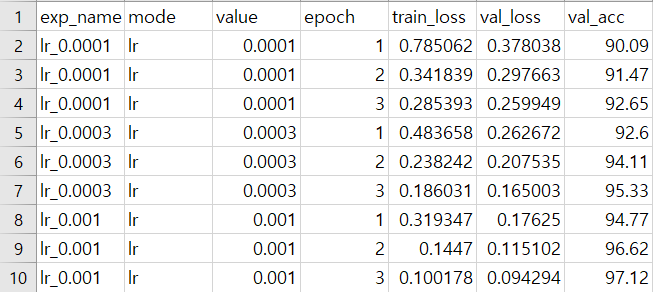




(2) epoch 변인 실험의 결과

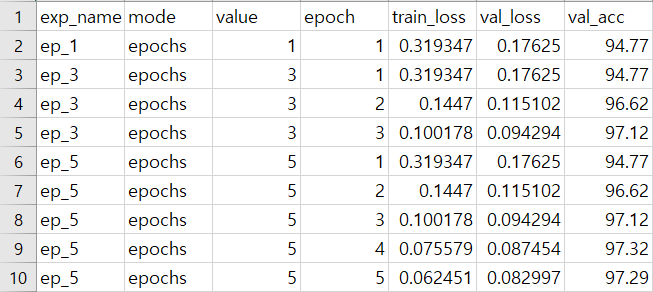

#**3-1. experiment1 analysis**

(1) 평가 데이터셋을 이용한 변인별 최종 정확도를 분석

(2) training loss 값들을 일종의 시계열 데이터라고 보고 numpy 내에 있는 Dynamic Mode Decomposition (DMD)을 이용해 수렴 정도에 어떤 변화가 있는지를 보조 지표로 확인

------------------------------------------------------

(1) 학습율과 에포크를 변인으로 한 최종 정확도를 요약하면 다음과 같다.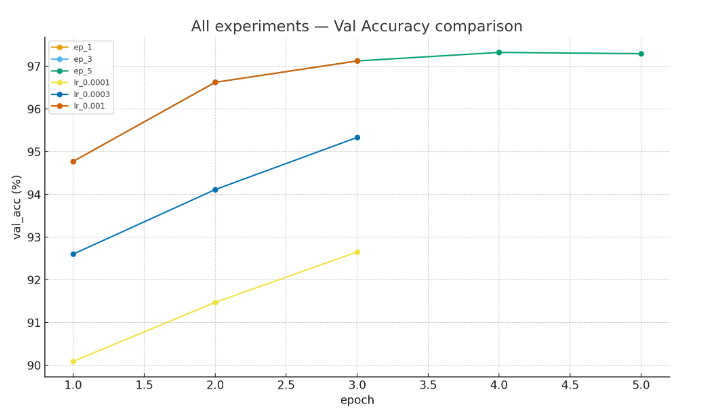

learning rate가 해당 실험에서 주어진 범위 안에서는 늘어날수록 전체적인 acc가 높아지는 것을 볼 수 있다. lr의 변화에 따른 acc의 경향성을 더 정확하게 확인하기 위해서는 더 많은 lr값들을 실험해야 할 필요성이 느껴진다.

또한 예상대로 epoch를 높일수록 acc가 증가하는 양상을 보였다. 여기서 주목해야 할 부분은 거의 epoch 5 근처에서 acc가 수렴하고 있음이 보여지는데, 이는 이 이상으로 더 모델의 정확도를 높이기 위해서는 단순한 epoch 증가로는 어렵다는 점을 시사한다. 이 상태에서 5 이상으로 에포크를 늘린다고 하더라도 과적합 등의 문제가 발생할 수 있으므로 이 이상의 acc 증가를 위해서는 다른 하이퍼 파라미터나 모델 구조를 고려해야 된다고 분석된다.

(2) DMD로 변인별 loss 감소 정도 비교

1. lr =  0.0001 일때의 train_loss 감소 경향

In [45]:
# 시계열 벡터 입력 --> 람다값 도출.
# 네트워크 전체를 해석하려면 수많은 파라미터의 비선형 시스템을 다뤄야 하지만,
 #loss 시퀀스만 보면 “수렴 속도”를 한두 개 숫자(람다)로 요약하기 편함.

import numpy as np

def estimate_dmd_lambda(wer_sequence):
    wer_sequence = np.array(wer_sequence)
    if len(wer_sequence) < 2:
        raise ValueError("loss 시퀀스는 최소 2개의 값이 필요합니다.")

    # X = [y1, y2, ..., y_{T-1}]
    X = wer_sequence[:-1]
    # X' = [y2, y3, ..., y_T]
    X_prime = wer_sequence[1:]

    numerator = np.dot(X_prime, X)
    denominator = np.dot(X, X)

    if denominator == 0:
        raise ValueError("분모가 0입니다. loss 시퀀스를 확인하세요.")

    A = numerator / denominator

    return A

if __name__ == "__main__":
    user_input = input("에포크별 loss 값들을 공백으로 구분하여 입력하세요 (예: 23.5 21.2 19.8 18.0):\n")
    try:
        wer_list = [float(x) for x in user_input.strip().split()]
        lambda_est = estimate_dmd_lambda(wer_list)
        print(f"추정된 λ (람다): {lambda_est:.4f}")
        if abs(lambda_est) < 1:
            print("→ loss가 수렴하는 경향입니다.")
        elif abs(lambda_est) == 1:
            print("→ loss가 일정한 경향입니다.")
        else:
            print("→ loss가 발산하는 경향입니다.")
    except Exception as e:
        print(f"오류 발생: {e}")

에포크별 loss 값들을 공백으로 구분하여 입력하세요 (예: 23.5 21.2 19.8 18.0):
0.785062  0.341839  0.285393
추정된 λ (람다): 0.4991
→ loss가 수렴하는 경향입니다.


lr = 0.0003일때의 train_loss 감소 경향

In [46]:
# 시계열 벡터 입력 --> 람다값 도출.
# 네트워크 전체를 해석하려면 수많은 파라미터의 비선형 시스템을 다뤄야 하지만,
 #loss 시퀀스만 보면 “수렴 속도”를 한두 개 숫자(람다)로 요약하기 편함.

import numpy as np

def estimate_dmd_lambda(wer_sequence):
    wer_sequence = np.array(wer_sequence)
    if len(wer_sequence) < 2:
        raise ValueError("loss 시퀀스는 최소 2개의 값이 필요합니다.")

    # X = [y1, y2, ..., y_{T-1}]
    X = wer_sequence[:-1]
    # X' = [y2, y3, ..., y_T]
    X_prime = wer_sequence[1:]

    numerator = np.dot(X_prime, X)
    denominator = np.dot(X, X)

    if denominator == 0:
        raise ValueError("분모가 0입니다. loss 시퀀스를 확인하세요.")

    A = numerator / denominator

    return A

if __name__ == "__main__":
    user_input = input("에포크별 loss 값들을 공백으로 구분하여 입력하세요 (예: 23.5 21.2 19.8 18.0):\n")
    try:
        wer_list = [float(x) for x in user_input.strip().split()]
        lambda_est = estimate_dmd_lambda(wer_list)
        print(f"추정된 λ (람다): {lambda_est:.4f}")
        if abs(lambda_est) < 1:
            print("→ loss가 수렴하는 경향입니다.")
        elif abs(lambda_est) == 1:
            print("→ loss가 일정한 경향입니다.")
        else:
            print("→ loss가 발산하는 경향입니다.")
    except Exception as e:
        print(f"오류 발생: {e}")

에포크별 loss 값들을 공백으로 구분하여 입력하세요 (예: 23.5 21.2 19.8 18.0):
0.483658  0.238242 0.186031
추정된 λ (람다): 0.5489
→ loss가 수렴하는 경향입니다.


lr = 0.001일때의 train_loss

In [47]:
# 시계열 벡터 입력 --> 람다값 도출.
# 네트워크 전체를 해석하려면 수많은 파라미터의 비선형 시스템을 다뤄야 하지만,
 #loss 시퀀스만 보면 “수렴 속도”를 한두 개 숫자(람다)로 요약하기 편함.

import numpy as np

def estimate_dmd_lambda(wer_sequence):
    wer_sequence = np.array(wer_sequence)
    if len(wer_sequence) < 2:
        raise ValueError("loss 시퀀스는 최소 2개의 값이 필요합니다.")

    # X = [y1, y2, ..., y_{T-1}]
    X = wer_sequence[:-1]
    # X' = [y2, y3, ..., y_T]
    X_prime = wer_sequence[1:]

    numerator = np.dot(X_prime, X)
    denominator = np.dot(X, X)

    if denominator == 0:
        raise ValueError("분모가 0입니다. loss 시퀀스를 확인하세요.")

    A = numerator / denominator

    return A

if __name__ == "__main__":
    user_input = input("에포크별 loss 값들을 공백으로 구분하여 입력하세요 (예: 23.5 21.2 19.8 18.0):\n")
    try:
        wer_list = [float(x) for x in user_input.strip().split()]
        lambda_est = estimate_dmd_lambda(wer_list)
        print(f"추정된 λ (람다): {lambda_est:.4f}")
        if abs(lambda_est) < 1:
            print("→ loss가 수렴하는 경향입니다.")
        elif abs(lambda_est) == 1:
            print("→ loss가 일정한 경향입니다.")
        else:
            print("→ loss가 발산하는 경향입니다.")
    except Exception as e:
        print(f"오류 발생: {e}")

에포크별 loss 값들을 공백으로 구분하여 입력하세요 (예: 23.5 21.2 19.8 18.0):
0.319347  0.1447  0.100178
추정된 λ (람다): 0.4939
→ loss가 수렴하는 경향입니다.


lr = 0.0003일때가 비교적 다른 lr 보다 수렴 정도가 높은 것을 알 수 있다. (0.5489)

하지만 학습 단계에서 loss의 감소 속도가 빨랐던 lr이 최종 acc가 가장 높았던 것은 아니었기에, “학습 loss 감소 속도가 빠르다 = 좋은 모델이다”는 직관은 다소 잘못되었을 수 있다는 것을 알 수 있다.

---------------------------

#**4. experiment2 : 활성화 함수를 변인으로 한 실험을 실행**

(1) 활성화 함수를 ReLU 에서 Tanh로 바꾸었을때 experimet1의 수치 (acc)들을 확인

MLP모델에서 활성화 함수를 Tanh로 변경

In [36]:
# nn.Tanh()가 변인이 된 모델입니다.
class MLP(nn.Module):
    def __init__(self, input_size=784, hidden_size=100, num_classes=10):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, num_classes)
        )
    def forward(self, x):
        return self.layers(x)

# 모델 확인 (간단 샘플)
_model = MLP()
total_params = sum(p.numel() for p in _model.parameters())
trainable_params = sum(p.numel() for p in _model.parameters() if p.requires_grad)
print("MLP summary:")
print(_model)
print(f"Total params: {total_params:,}, Trainable: {trainable_params:,}")

MLP summary:
MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)
Total params: 79,510, Trainable: 79,510


--------------------------------------------------------------------------------

활성화 함수를 Tanh로 변경하였을 때의 experimet1의 값들의 결과는 다음과 같다.

In [39]:
# 학습률 실험: lr만 바뀌고 epochs는 3을 사용하였습니다.
csv_path_lr, summaries_lr = run_experiments(
    mode="lr",
    lr_list=[1e-4, 3e-4, 1e-3],   # 바꾸고 싶은 lr 리스트
    baseline_epochs=3,
    batch_size=128,
    test_batch_size=1000,
    seed=42,
    results_dir="./exp_results",
    csv_name="mnist_lr_exps.csv",
    save_best_ckpt=True
)

# 에포크 실험: epochs만 바뀌어야 합니다.  (lr은 baseline_lr 사용)
csv_path_ep, summaries_ep = run_experiments(
    mode="epochs",
    epoch_list=[1, 3, 5],         # 바꾸고 싶은 epoch 리스트
    baseline_lr=1e-3,
    batch_size=128,
    test_batch_size=1000,
    seed=42,
    results_dir="./exp_results",
    csv_name="mnist_epoch_exps.csv",
    save_best_ckpt=True
)

# 결과 확인 (요약)
print("\nLR experiments summary:", summaries_lr)
print("\nEpoch experiments summary:", summaries_ep)


=== 실험: lr_0.0001 | epochs=3 ===
[lr_0.0001] Ep 1/3 | train_loss=0.8780 | val_loss=0.4604 | val_acc=89.67%
[lr_0.0001] Ep 2/3 | train_loss=0.3922 | val_loss=0.3268 | val_acc=91.37%
[lr_0.0001] Ep 3/3 | train_loss=0.3075 | val_loss=0.2758 | val_acc=92.35%
완료: lr_0.0001 | best_val_acc=92.35% | total_elapsed=73.7s | ckpt=./exp_results/lr_0.0001_best.pth

=== 실험: lr_0.0003 | epochs=3 ===
[lr_0.0003] Ep 1/3 | train_loss=0.5309 | val_loss=0.2822 | val_acc=92.25%
[lr_0.0003] Ep 2/3 | train_loss=0.2519 | val_loss=0.2210 | val_acc=93.81%
[lr_0.0003] Ep 3/3 | train_loss=0.1995 | val_loss=0.1838 | val_acc=94.82%
완료: lr_0.0003 | best_val_acc=94.82% | total_elapsed=80.0s | ckpt=./exp_results/lr_0.0003_best.pth

=== 실험: lr_0.001 | epochs=3 ===
[lr_0.001] Ep 1/3 | train_loss=0.3359 | val_loss=0.1942 | val_acc=94.40%
[lr_0.001] Ep 2/3 | train_loss=0.1626 | val_loss=0.1467 | val_acc=95.75%
[lr_0.001] Ep 3/3 | train_loss=0.1185 | val_loss=0.1209 | val_acc=96.36%
완료: lr_0.001 | best_val_acc=96.36% | tot

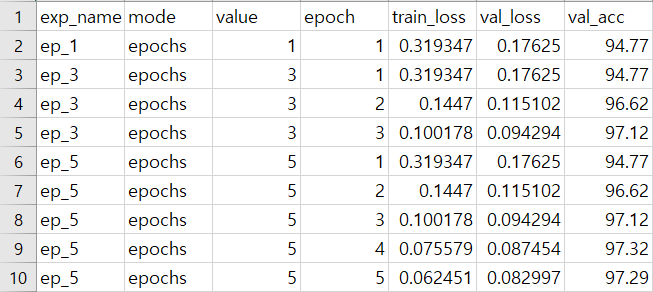



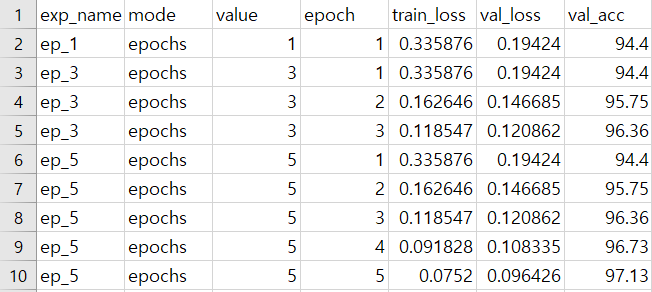



 # **4-1. experiment2 analysis**
  
 (1) 최종 acc가 활성화 함수의 변화에 따라 어떻게 달라졌는지, 원인이 있다면 무엇인지 분석

 (2) 앞서 사용했던 DMD를 통해 학습 loss의 수렴 양상이 활성화 함수에 따라 어떻게 변화했는지 분석

--------------------------------------------------------------------------------

(1) 활성화 함수가 달라졌을때의 최종 정확도를 정리하면 다음과 같다. 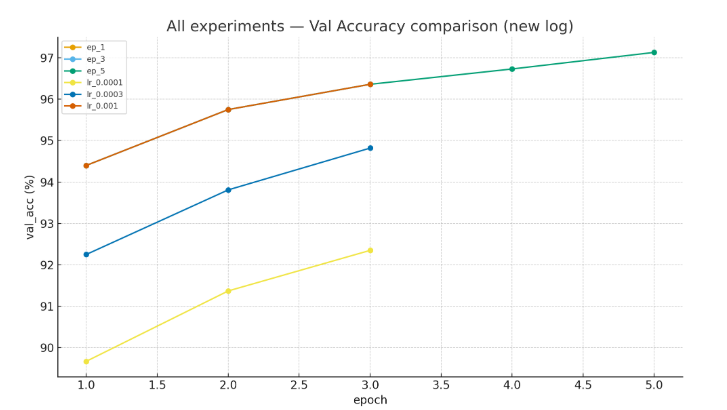

활성화 함수가 ReLU 였을때와 같이 lr가 증가함에 따라서 정확도가 높아지는 부분은 실험 1과 동일하게 관찰된다.
주목할 부분은 Tanh를 활성화 함수로 사용하니 epoch 5 근처에서 수렴하던 acc가 계속해서 향상하고 있는것을 알 수 있다. 혹시 원인이 과적합은 아닌지 (Tanh의 잘 알려져 있는 위험성) 확인해 볼 필효가 있다.

(2) DMD로 loss감소 정도 비교

1. relu 썼을시 loss 감소 경향

In [42]:
# 시계열 벡터 입력 --> 람다값 도출.
# 네트워크 전체를 해석하려면 수많은 파라미터의 비선형 시스템을 다뤄야 하지만,
 #loss 시퀀스만 보면 “수렴 속도”를 한두 개 숫자(람다)로 요약하기 편함.

import numpy as np

def estimate_dmd_lambda(wer_sequence):
    wer_sequence = np.array(wer_sequence)
    if len(wer_sequence) < 2:
        raise ValueError("loss 시퀀스는 최소 2개의 값이 필요합니다.")

    # X = [y1, y2, ..., y_{T-1}]
    X = wer_sequence[:-1]
    # X' = [y2, y3, ..., y_T]
    X_prime = wer_sequence[1:]

    numerator = np.dot(X_prime, X)
    denominator = np.dot(X, X)

    if denominator == 0:
        raise ValueError("분모가 0입니다. loss 시퀀스를 확인하세요.")

    A = numerator / denominator

    return A

if __name__ == "__main__":
    user_input = input("에포크별 loss 값들을 공백으로 구분하여 입력하세요 (예: 23.5 21.2 19.8 18.0):\n")
    try:
        wer_list = [float(x) for x in user_input.strip().split()]
        lambda_est = estimate_dmd_lambda(wer_list)
        print(f"추정된 λ (람다): {lambda_est:.4f}")
        if abs(lambda_est) < 1:
            print("→ loss가 수렴하는 경향입니다.")
        elif abs(lambda_est) == 1:
            print("→ loss가 일정한 경향입니다.")
        else:
            print("→ loss가 발산하는 경향입니다.")
    except Exception as e:
        print(f"오류 발생: {e}")

에포크별 loss 값들을 공백으로 구분하여 입력하세요 (예: 23.5 21.2 19.8 18.0):
0.319347 0.1447  0.100178 0.075579  0.062451
추정된 λ (람다): 0.5264
→ loss가 수렴하는 경향입니다.


2. tanh 썼을시 감소 경향

In [44]:
# 시계열 벡터 입력 --> 람다값 도출.
# 네트워크 전체를 해석하려면 수많은 파라미터의 비선형 시스템을 다뤄야 하지만,
 #loss 시퀀스만 보면 “수렴 속도”를 한두 개 숫자(람다)로 요약하기 편함.

import numpy as np

def estimate_dmd_lambda(wer_sequence):
    wer_sequence = np.array(wer_sequence)
    if len(wer_sequence) < 2:
        raise ValueError("loss 시퀀스는 최소 2개의 값이 필요합니다.")

    # X = [y1, y2, ..., y_{T-1}]
    X = wer_sequence[:-1]
    # X' = [y2, y3, ..., y_T]
    X_prime = wer_sequence[1:]

    numerator = np.dot(X_prime, X)
    denominator = np.dot(X, X)

    if denominator == 0:
        raise ValueError("분모가 0입니다. loss 시퀀스를 확인하세요.")

    A = numerator / denominator

    return A

if __name__ == "__main__":
    user_input = input("에포크별 loss 값들을 공백으로 구분하여 입력하세요 (예: 23.5 21.2 19.8 18.0):\n")
    try:
        wer_list = [float(x) for x in user_input.strip().split()]
        lambda_est = estimate_dmd_lambda(wer_list)
        print(f"추정된 λ (람다): {lambda_est:.4f}")
        if abs(lambda_est) < 1:
            print("→ loss가 수렴하는 경향입니다.")
        elif abs(lambda_est) == 1:
            print("→ loss가 일정한 경향입니다.")
        else:
            print("→ loss가 발산하는 경향입니다.")
    except Exception as e:
        print(f"오류 발생: {e}")

에포크별 loss 값들을 공백으로 구분하여 입력하세요 (예: 23.5 21.2 19.8 18.0):
0.335876  0.162646  0.118547  0.091828  0.0752
추정된 λ (람다): 0.5669
→ loss가 수렴하는 경향입니다.


활성화 함수를 Tanh로 사용하였을때 수렴하는 정도가 더 크다고 볼 수 있으나 차이가 크지는 않다. 오히려 수렴 정도가 크다는 것이 과적합의 지표로 연결시킬 수 있을거라는 예상을 하게된다.

# 5. **conclusion**

(1) 실험에서 주어진 lr 범위 내에서는 (3개 값) lr가 높을수록  전체적인 acc도 높다는 것을 알 수 있었다.





(2) 해당 실험에서 이용한 MLP 모델의 구조로는 에포크 5 근처에서 acc가 수렴하는 것을 관찰할 수 있었으나,  활성화 함수를 Tanh로 변경시 acc가 에포크 5 이상에서도 계속해서 상승하는 것을 볼 수 있었다. 다만, 이는 과적합에 취약한 Tanh의 특성으로 인한 것일 수 있으므로 acc의 개선의 원인을 정확하게 분석할 필요가 있어 보인다.






(3) 시계열 분석에 사용하는 도구인 DMD를 통해 학습 loss 변화를 분석한 결과 loss 수렴 정도와 최종 acc의 관계는 약한 것으로 예상된다. DMD를 최종 평가 지표로 사용하기에는 한계가 있다는 점을 시사한다. 다만 Tanh 이용하여 최종 acc가 상승하며 과적합이 예상되는 상황에서 DMD의 람다 값도 커진 것으로 보아 이를 과적합의 초기 지표로 사용할 수 있을 것이라는 예상을 해본다. (검증 필요)

# **6. 참고 자료 및 참고 문헌 **

(1) 코드 구현 단계에서 LLM (GPT-5 Thinking mini)을 사용한 부분은 각주로 표시함

(2) <딥러닝 파이토치 교과서>, 서지영, 길벗출판사, 2024

(3) Dynamic mode decomposition, wikipedia 검색 (2025.10.6)